# Data Preprocessing and Classification Notebook

This notebook demonstrates how to load the `train.csv` dataset, perform cleaning and preprocessing and train a Random Forest model. We will also display intermediate results and evaluation metrics.

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Load the Data
We load the dataset from the file `train.csv` and use a sample to reduce memory usage.


In [27]:
# Load the dataset
df = pd.read_csv(r'C:\Users\nicol\OneDrive\Escritorio\ai_data\train.csv')
df_sample = df.head(20000)
print("Data shape:", df_sample.shape)
display(df_sample.head())

Data shape: (20000, 21)


,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,...,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


## Select Relevant Columns
We select a subset of columns for modeling. The target variable is `RENDIMIENTO_GLOBAL` and the features include both categorical and numerical columns.


In [28]:
selected_columns = [
    "ESTU_PRGM_ACADEMICO",
    "FAMI_ESTRATOVIVIENDA",
    "FAMI_TIENEINTERNET",
    "FAMI_EDUCACIONPADRE",
    "FAMI_TIENECOMPUTADOR",
    "coef_1", "coef_2", "coef_3", "coef_4"
]

X_sample = df_sample[selected_columns]
y_sample = df_sample["RENDIMIENTO_GLOBAL"]

# Fill missing values for features. In categorical columns we use "unknown"
X_sample_filled = X_sample.fillna("unknown")

## Preprocess Categorical Data
We use one-hot encoding for the categorical features for clarity.
Define the categorical and numerical columns for processing.

In [32]:
cat_cols = [
    "ESTU_PRGM_ACADEMICO",
    "FAMI_ESTRATOVIVIENDA",
    "FAMI_TIENEINTERNET",
    "FAMI_EDUCACIONPADRE",
    "FAMI_TIENECOMPUTADOR"
]

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

# Fit and transform
X_cat_processed = cat_pipeline.fit_transform(df[cat_cols])

# Build a summary DataFrame
onehot_names = cat_pipeline.named_steps['onehot'].get_feature_names_out(cat_cols)
summary = []
for col in cat_cols:
    vc = df[col].value_counts(dropna=False)
    summary.append({
        'feature': col,
        'unique_values': vc.shape[0],
        'dummies_created': sum(1 for n in onehot_names if n.startswith(f"{col}_")),
        'top_3_levels': vc.head(3).index.tolist()
    })
summary_df = pd.DataFrame(summary)
print("Categorical encoding summary:")
print(summary_df.to_string(index=False))

Categorical encoding summary:
             feature  unique_values  dummies_created                                                                              top_3_levels
 ESTU_PRGM_ACADEMICO            948              948                                 [DERECHO, ADMINISTRACION DE EMPRESAS, CONTADURIA PUBLICA]
FAMI_ESTRATOVIVIENDA              8                8                                                         [Estrato 2, Estrato 3, Estrato 1]
  FAMI_TIENEINTERNET              3                3                                                                             [Si, No, nan]
 FAMI_EDUCACIONPADRE             13               13 [Secundaria (Bachillerato) completa, Primaria incompleta, Educación profesional completa]
FAMI_TIENECOMPUTADOR              3                3                                                                             [Si, No, nan]


## Preprocess Numerical Data
We convert numerical columns to float, replace string "na" values with NaN, impute missing values using the mean strategy, and then standardize them.

In [33]:
num_cols = ["coef_1", "coef_2", "coef_3", "coef_4"]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler()),
])

# Fit and transform
X_num_processed = num_pipeline.fit_transform(df[num_cols])

# Quick summary
num_summary = pd.DataFrame(X_num_processed, columns=num_cols).describe().T[['mean','std','min','max']]
print("Numerical features after Power + StandardScaler:")
print(num_summary.to_string())

Numerical features after Power + StandardScaler:
                mean       std       min       max
coef_1  5.058449e-17  1.000001 -2.840917  2.549072
coef_2 -6.819671e-16  1.000001 -2.477949  2.718592
coef_3 -6.549306e-16  1.000001 -2.353291  2.111930
coef_4 -1.214849e-16  1.000001 -2.083248  1.951268


In [35]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
], remainder='drop')  # drop any other columns

# Fit once on full DataFrame
X_all = preprocessor.fit_transform(df[num_cols + cat_cols])
print("Full feature matrix shape after preprocessing:", X_all.shape)

Full feature matrix shape after preprocessing: (692500, 979)


## Split Data and Train Model
We split the data into training and testing sets, then train a Random Forest classifier.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

y_all = df['RENDIMIENTO_GLOBAL']

# 80/20 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.3580
              precision    recall  f1-score   support

        alto       0.45      0.52      0.48     35124
        bajo       0.38      0.42      0.40     34597
  medio-alto       0.28      0.24      0.26     34324
  medio-bajo       0.29      0.26      0.27     34455

    accuracy                           0.36    138500
   macro avg       0.35      0.36      0.35    138500
weighted avg       0.35      0.36      0.35    138500



## Model Evaluation

We predict labels for the test set and evaluate the model using accuracy and a detailed classification report.
Additionally, a bar plot shows the predicted distribution of performance levels.

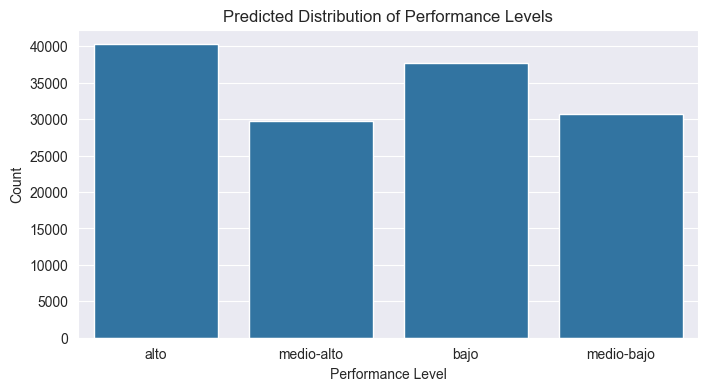

In [37]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y_pred)
plt.title('Predicted Distribution of Performance Levels')
plt.xlabel('Performance Level')
plt.ylabel('Count')
plt.show()

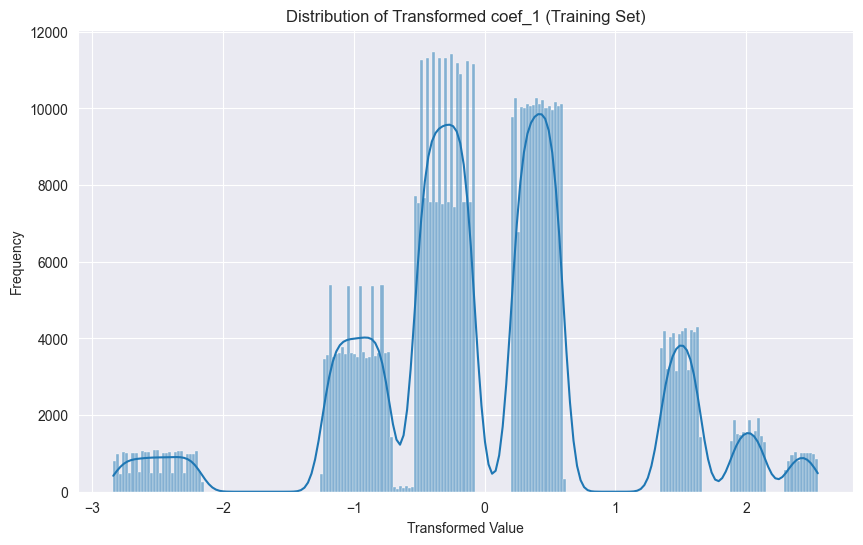

In [38]:
idx = num_cols.index('coef_1')

plt.figure(figsize=(10, 6))
sns.histplot(X_train[:, idx], kde=True)
plt.title('Distribution of Transformed coef_1 (Training Set)')
plt.xlabel('Transformed Value')
plt.ylabel('Frequency')
plt.show()